The path is correct and the file exists.
Detected skew angle: -90.00
(2338, 1653)


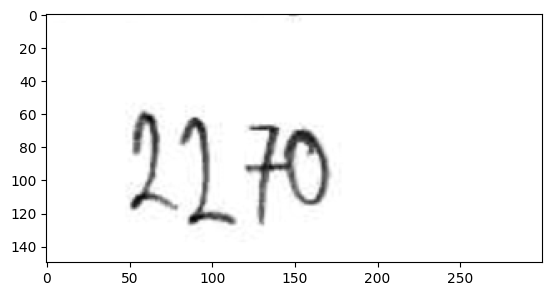

OCR Result for SKM_C22724072909270_0019.jpg: n1 o



KeyboardInterrupt: Interrupted by user

In [16]:
"""
Script 1: AutoFormPreprocessor

Description:
This script processes scanned images of micro-section forms by correcting skew, extracting a predefined 
Region of Interest (ROI) for the section ID, and renaming the files based on user input. 
An OCR-based function (Tesseract) is included but currently not used for final renaming due to low reliability 
on handwritten text. Instead, a semi-automatic approach is used for greater accuracy and control.

To ensure the script works correctly, the user must define:
- input_dir:      path to the folder containing raw scanned images (.jpg)
- preprocessed_dir: path to save deskewed and ROI images
- output_dir:     path to save final renamed files
- x, y, w, h:      coordinates and size of the ROI where the Section ID is located

Note on OCR:
An OCR-based method using Tesseract (via pytesseract) was initially implemented to automate the extraction 
of Section IDs. However, due to inconsistent accuracy on handwritten forms, the workflow was adjusted to 
a semi-automatic approach. The OCR functionality is retained here for reference and to maintain consistency 
with the original project abstract and conference presentation.
"""

import pytesseract
from PIL import Image
import cv2
import numpy as np
import re
import os
from matplotlib import pyplot as plt
import time

# ---------------------------------------------
# USER SETTINGS (EDIT BEFORE RUNNING)
# ---------------------------------------------
    input_dir = r"C:\path_to_input_dir" # folder with input images
    preprocessed_dir = r"C:\path_to_preprocessed_dir" # folder for output work-version preprocessed images
    output_dir = r"path_to_output_dir" # folder for output final preprocessed images
    x, y, w, h = 1040, 260, 200, 100 #set the ROI here
# ---------------------------------------------
# FUNCTIONS
# ---------------------------------------------
def grayscale(image: np.ndarray) -> np.ndarray:
    """Convert an image to grayscale."""
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def get_skew_angle(cv_image: np.ndarray) -> float:
    """Calculate the skew angle of an image."""
    blur = cv2.GaussianBlur(cv_image, (9, 9), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 5))
    dilate = cv2.dilate(thresh, kernel, iterations=5)

    contours, _ = cv2.findContours(dilate, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        raise ValueError("No contours found in the image.")

    largest_contour = max(contours, key=cv2.contourArea)
    min_area_rect = cv2.minAreaRect(largest_contour)

    angle = min_area_rect[-1]
    if angle < -45:
        angle += 90
    return -1.0 * angle

def rotate_image(cv_image: np.ndarray, angle: float) -> np.ndarray:
    """Rotate an image by a given angle."""
    (h, w) = cv_image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(cv_image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

def deskew(cv_image: np.ndarray) -> np.ndarray:
    """Correct the skew of an image."""
    angle = get_skew_angle(cv_image)
    print(f"Detected skew angle: {angle:.2f}")
    if abs(angle) > 45:
        return cv_image
    return rotate_image(cv_image, -1.0 * angle)

def magnify(cropped: np.ndarray, scale_percent: int = 150) -> np.ndarray:
    """Magnify a cropped portion of an image."""
    width = int(cropped.shape[1] * scale_percent / 100)
    height = int(cropped.shape[0] * scale_percent / 100)
    return cv2.resize(cropped, (width, height), interpolation=cv2.INTER_LINEAR)

def display(image):
    plt.imshow(image, cmap='gray') 
    return plt.show()

def preprocess_img(image: np.ndarray) -> np.ndarray:
    """Preprocess an image for OCR."""
    gray = grayscale(image)
    return deskew(gray)
    
def extract_region_of_interest(img: np.ndarray, x: int, y: int, w: int, h: int) -> np.ndarray:
    """Extract and resize a region of interest from an image."""
    cropped = img[y:y+h, x:x+w]
    return magnify(cropped)

def execute_ocr(image: np.ndarray, lang: str = 'ces', config: str = '--oem 3 --psm 7') -> str:
    """Perform OCR on a given image."""
    pil_image = Image.fromarray(image)
    return pytesseract.image_to_string(pil_image, lang=lang, config=config)

def sanitize_filename(filename: str) -> str:
    """Sanitize a string to be used as a filename."""
    return re.sub(r'[\\/*?:"<>|\n]', '_', filename)

def save_image(image: np.ndarray, filename: str) -> None:
    """Save an image to the disk."""
    cv2.imwrite(filename, image)
    
def get_unique_filename(output_dir: str, filename: str) -> str:
    """Prompt the user to enter a unique filename if the given filename already exists."""
    while os.path.exists(os.path.join(output_dir, filename)):
        print(f"Filename '{filename}' already exists.")
        new_filename = input("Please enter a new filename (without extension): ").strip()
        if new_filename:
            filename = f"{new_filename}.jpg"
        else:
            print("Invalid input. Please try again.")
    return filename
# ---------------------------------------------
# MAIN PROCESS
# ---------------------------------------------
def main(input_dir: str, preprocessed_dir: str, output_dir: str, x: int, y: int, w: int, h: int) -> None:
    """Main function to process all images in a directory, perform OCR, and save the result."""
    try:
        start_time = time.time()
        accepted_count = 0
        manual_count = 0
        original_count = 0
        
        if not os.path.exists(preprocessed_dir):
            os.makedirs(preprocessed_dir)
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        for index, filename in enumerate(os.listdir(input_dir)):
            if filename.lower().endswith(".jpg"):
                img_path = os.path.join(input_dir, filename)
                if os.path.exists(img_path):
                    print("The path is correct and the file exists.")
                else:
                    print("The path is incorrect or the file does not exist.")
                
                img_original = cv2.imread(img_path)
                if img_original is None:
                    print(f"Warning: Image {filename} could not be loaded.")
                    continue
                
                preprocessed_img = preprocess_img(img_original)

                print(preprocessed_img.shape)
                preprocessed_filename = os.path.join(preprocessed_dir, f"preprocess{index+1}.jpg")

                region_of_interest = extract_region_of_interest(preprocessed_img, x, y, w, h)
                display(region_of_interest)
                
                roi_filename = os.path.join(preprocessed_dir, f"roi{index+1}.jpg")
                save_image(region_of_interest, roi_filename)
                
                ocr_result = execute_ocr(region_of_interest)
                print(f"OCR Result for {filename}: {ocr_result}")

                correct_name = input("Is this the correct name? If not, type the correct one (or press 'o' to keep original name, Enter to accept OCR result): ")

                if correct_name.strip() == "":  # If the user has not typed anything, the OCR result will be used
                    sanitized_result = sanitize_filename(ocr_result.strip())
                    accepted_count += 1
                elif correct_name.strip().lower() == "o":  # If the user presses 'o', the original name will be preserved
                    sanitized_result = os.path.splitext(filename)[0]
                    original_count += 1
                else:  # If the user entered the correct name
                    sanitized_result = sanitize_filename(correct_name.strip())
                    manual_count += 1

                # Check if a file with the same name already exists and edit the name if so
                output_filename = f"CS_{sanitized_result}.jpg"
                unique_filename = get_unique_filename(output_dir, output_filename)

                # Save image with unique name
                save_image(preprocessed_img, os.path.join(output_dir, unique_filename))

        elapsed = time.time() - start_time
        total = accepted_count + manual_count
        accuracy = (accepted_count / total * 100) if total > 0 else 0

        print("\n--- OCR Accuracy Report ---")
        print(f"Accepted OCR results: {accepted_count}")
        print(f"Manual corrections: {manual_count}")
        print(f"Keeping original name due inability to read the No.: {original_count}")
        print(f"Estimated accuracy: {accuracy:.2f}%")
        print(f"Elapsed time: {elapsed:.2f} seconds")
        
    except Exception as e:
        print(f"An error occurred: {e}")

if __name__ == "__main__":
    main(input_dir, preprocessed_dir, output_dir, x, y, w, h)